Импортируем необходимые библиотеки

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
import datetime as dt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from scipy import sparse
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import chi2
from sklearn.metrics import matthews_corrcoef

In [49]:
df = pd.read_csv('150users/user0486.csv')
df

,user_id,timestamp,site
0,1,2013-11-19 13:32:51,fpdownload2.macromedia.com
1,1,2013-11-19 13:32:59,www.google.fr
2,1,2013-11-19 13:33:00,www.google.com
3,1,2013-11-19 13:33:00,www.google.fr
4,1,2013-11-19 13:33:00,www.bing.com
...,...,...,...
6515,1,2014-03-31 16:45:40,www.google.com
6516,1,2014-03-31 16:45:47,www.google.fr
6517,1,2014-03-31 16:45:48,go.microsoft.com
6518,1,2014-03-31 16:45:48,ieonline.microsoft.com


Создадим переменную *path_to_data*, которая будет хранить путь до датасетов

In [2]:
path_to_data = '150users/*'

В качестве пользователя, которого необходимо будет идентифицировать, выберем датасет с медианным количеством строк. Чтобы его обнаружить, была написана и использована функция *find_median_user()*

In [5]:
def find_median_user(csv_files_path):
    list_of_files = glob(csv_files_path)
    length_list = []
    for file in list_of_files:
        data = pd.read_csv(file)
        length_list.append(len(data))
    length_list.sort()
    for file in list_of_files:
        data = pd.read_csv(file)
        if len(data) == length_list[75]:
            return file

In [6]:
%%time
median_user = find_median_user(path_to_data)
median_user

Wall time: 2.36 s


'150users\\user0486.csv'

Создадим признак *user_id* в каждом датасете. Во всех датасетах, кроме '150users\\user0486.csv', *user_id* будет равен 0. В '150users\\user0486.csv' *user_id* будет равен 1.

In [36]:
def create_user_id(file_target,csv_file_path):
    list_of_files = glob(csv_file_path)
    for file in list_of_files:
        data = pd.read_csv(file)
        if file == file_target:
            data.insert(0,'user_id',1)
        else:
            data.insert(0,'user_id',0)
        data.to_csv(file, index = False)

In [15]:
%%time
create_user_id(median_user, path_to_data)

Wall time: 12 s


Теперь объединим все датасеты в один. Одна строка будет приравниваться к одной веб-сессии. Максимальное количество посещенных сайтов в одной сессии - 20. Если время посещения следующего сайта более 5 минут, то сессия считается новой.

In [18]:
def create_dataframe(csv_file_path):
    list_of_elements = {}
    list_of_files = glob(csv_file_path)
    columns = []
    
    for i in range(1,21):
        columns.append('time' + str(i))
        columns.append('site' + str(i))
        if i==40:
            columns.append('target')
        
    final_data = pd.DataFrame(columns = columns)
    
    for file in list_of_files:
        data = pd.read_csv(file)
        data['timestamp'] = data['timestamp'].apply(pd.to_datetime)
        counter = 1
        for i in range(len(data)):
            if i == 0:
                list_of_elements['time1'] = data['timestamp'][i]
                list_of_elements['site1'] = data['site'][i]
                counter += 1
                continue
            if (data['timestamp'][i-1] - data['timestamp'][i]).total_seconds() >= -300 and counter != 21:
                list_of_elements['time' + str(counter)] = data['timestamp'][i]
                list_of_elements['site' + str(counter)] = data['site'][i]
            else:
                if list_of_elements:
                    list_of_elements['target'] = data['user_id'][i]
                    final_data = final_data.append(list_of_elements, ignore_index=True)
                    list_of_elements.clear()
                    counter = 0
                if not list_of_elements:
                    counter = 1
                    list_of_elements['time1'] = data['timestamp'][i]
                    list_of_elements['site1'] = data['site'][i]
            if i == len(data) - 1:
                list_of_elements['target'] = data['user_id'][i]
                final_data = final_data.append(list_of_elements, ignore_index=True)
                list_of_elements.clear()
            counter += 1
    return final_data

In [19]:
%%time
data = create_dataframe(path_to_data)
data

Wall time: 1h 55min 13s


,time1,site1,time2,site2,time3,site3,time4,site4,time5,site5,...,site16,time17,site17,time18,site18,time19,site19,time20,site20,target
0,2013-11-15 08:01:09,www.google.fr,2013-11-15 08:01:10,www.google.fr,2013-11-15 08:01:11,apis.google.com,2013-11-15 08:01:12,www.google.com,2013-11-15 08:01:16,www.google.fr,...,img.babylon.com,2013-11-15 08:03:56,go.microsoft.com,2013-11-15 08:03:56,ieonline.microsoft.com,NaN,NaN,NaN,NaN,0.0
1,2013-11-15 08:29:00,javadl-esd-secure.oracle.com,2013-11-15 08:29:04,javadl-esd-secure.oracle.com,2013-11-15 08:29:06,img.babylon.com,2013-11-15 08:29:07,fpdownload2.macromedia.com,2013-11-15 08:29:17,www.google.fr,...,NaN,NaT,NaN,NaT,NaN,NaN,NaN,NaN,NaN,0.0
2,2013-11-15 09:02:32,img.babylon.com,2013-11-15 09:02:32,www.google.com,2013-11-15 09:02:36,www.google.fr,2013-11-15 09:02:53,www.google.fr,2013-11-15 09:02:54,www.google.fr,...,NaN,NaT,NaN,NaT,NaN,NaN,NaN,NaN,NaN,0.0
3,2013-11-15 09:11:53,modis.gsfc.nasa.gov,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,...,NaN,NaT,NaN,NaT,NaN,NaN,NaN,NaN,NaN,0.0
4,2013-11-15 09:36:13,www.google.fr,2013-11-15 09:36:19,clients1.google.fr,2013-11-15 09:36:19,www.google.fr,2013-11-15 09:36:22,www.google.fr,2013-11-15 09:36:26,www.google.fr,...,khms0.google.fr,2013-11-15 09:36:33,khms1.google.fr,2013-11-15 09:36:33,mts0.google.com,2013-11-15 09:36:33,maps.google.fr,2013-11-15 09:36:34,maps.google.fr,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83261,2014-04-14 17:12:43,platform.tumblr.com,2014-04-14 17:13:29,www.linkedin.com,2014-04-14 17:13:45,www.google.com,2014-04-14 17:13:46,sb-ssl.google.com,2014-04-14 17:13:48,ocsp.verisign.com,...,cimg.leguide.com,2014-04-14 17:13:52,ajax.googleapis.com,2014-04-14 17:13:52,code.jquery.com,2014-04-14 17:13:52,cdnjs.cloudflare.com,2014-04-14 17:13:52,annonces-immobilier.liberation.fr,0.0
83262,2014-04-14 17:13:52,flux.liberation.fr,2014-04-14 17:13:53,code.jquery.com,2014-04-14 17:13:53,annonces-immobilier.liberation.fr,2014-04-14 17:13:53,flux.liberation.fr,2014-04-14 17:13:53,pointscommuns.liberation.fr,...,ajax.googleapis.com,2014-04-14 17:13:55,s1.libe.com,2014-04-14 17:13:57,cdnjs.cloudflare.com,2014-04-14 17:13:57,code.jquery.com,2014-04-14 17:14:50,oracle.padiact.com,0.0
83263,2014-04-14 17:14:50,d2xgf76oeu9pbh.cloudfront.net,2014-04-14 17:15:48,ocsp.digicert.com,2014-04-14 17:16:43,www.google.com,2014-04-14 17:16:44,www.google.fr,2014-04-14 17:17:25,md1.libe.com,...,www.facebook.com,2014-04-14 17:17:32,pixel.alephd.com,2014-04-14 17:17:33,zor.fyre.co,2014-04-14 17:17:33,videosfr.s3.amazonaws.com,2014-04-14 17:17:33,pixel.alephd.com,0.0
83264,2014-04-14 17:17:33,hitcount.liberation.fr,2014-04-14 17:17:33,avatars.fyre.co,2014-04-14 17:17:34,ocsp.digicert.com,2014-04-14 17:17:35,md1.libe.com,2014-04-14 17:17:36,s1.libe.com,...,NaN,NaT,NaN,NaT,NaN,NaN,NaN,NaN,NaN,0.0


Отсортируем строки по времени начала сессии и сохраним датасет

In [64]:
data = data.sort_values('time1')
data.to_csv('sessions_with_domains.csv', index = False)

In [2]:
data = pd.read_csv('sessions_with_domains.csv')
data

,time1,site1,time2,site2,time3,site3,time4,site4,time5,site5,...,site16,time17,site17,time18,site18,time19,site19,time20,site20,target
0,2013-11-15 08:01:09,www.google.fr,2013-11-15 08:01:10,www.google.fr,2013-11-15 08:01:11,apis.google.com,2013-11-15 08:01:12,www.google.com,2013-11-15 08:01:16,www.google.fr,...,img.babylon.com,2013-11-15 08:03:56,go.microsoft.com,2013-11-15 08:03:56,ieonline.microsoft.com,NaN,NaN,NaN,NaN,0.0
1,2013-11-15 08:04:12,armmf.adobe.com,2013-11-15 08:05:31,www.google.fr,2013-11-15 08:05:32,apis.google.com,2013-11-15 08:05:32,www.google.com,2013-11-15 08:05:35,www.google.fr,...,www.google.fr,2013-11-15 08:06:20,apis.google.com,2013-11-15 08:06:23,www.google.com,2013-11-15 08:06:29,apis.google.com,2013-11-15 08:06:29,www.google.com,0.0
2,2013-11-15 08:06:29,www.google.fr,2013-11-15 08:06:30,www.google.fr,2013-11-15 08:06:30,ajax.googleapis.com,2013-11-15 08:06:30,www.sol-solution.com,2013-11-15 08:06:31,www.sol-solution.com,...,www.google.fr,2013-11-15 08:07:50,www.apogeedigital.com,2013-11-15 08:07:51,www.apogeedigital.com,2013-11-15 08:07:52,www.apogeedigital.com,2013-11-15 08:07:53,www.apogeedigital.com,0.0
3,2013-11-15 08:07:35,www.google.com,2013-11-15 08:07:35,www.google.fr,2013-11-15 08:07:47,www.google.fr,2013-11-15 08:07:47,apis.google.com,2013-11-15 08:07:47,id.google.fr,...,blast.ncbi.nlm.nih.gov,2013-11-15 08:08:34,blast.ncbi.nlm.nih.gov,2013-11-15 08:08:35,blast.ncbi.nlm.nih.gov,2013-11-15 08:08:38,blast.ncbi.nlm.nih.gov,2013-11-15 08:08:39,blast.ncbi.nlm.nih.gov,0.0
4,2013-11-15 08:07:54,www.apogeedigital.com,2013-11-15 08:07:55,www.apogeedigital.com,2013-11-15 08:08:00,www.apogeedigital.com,2013-11-15 08:08:01,www.apogeedigital.com,2013-11-15 08:08:02,www.apogeedigital.com,...,www.facebook.com,2013-11-15 08:08:21,www.google.com,2013-11-15 08:08:21,www.google.fr,2013-11-15 08:08:27,www.apogeedigital.com,2013-11-15 08:08:28,www.apogeedigital.com,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83261,2014-05-28 19:02:25,www.mangareader.net,2014-05-28 19:02:25,www.facebook.com,2014-05-28 19:02:51,www.mangareader.net,2014-05-28 19:02:52,www.facebook.com,2014-05-28 19:02:53,i6.mangareader.net,...,www.facebook.com,2014-05-28 19:03:01,www.mangareader.net,2014-05-28 19:03:02,www.mangareader.net,2014-05-28 19:03:02,www.facebook.com,2014-05-28 19:03:03,www.mangareader.net,0.0
83262,2014-05-28 19:03:03,i5.mangareader.net,2014-05-28 19:03:04,www.facebook.com,2014-05-28 19:03:04,www.mangareader.net,2014-05-28 19:03:50,www.mangareader.net,2014-05-28 19:03:51,www.mangareader.net,...,www.facebook.com,2014-05-28 19:04:46,i3.mangareader.net,2014-05-28 19:05:02,www.mangareader.net,2014-05-28 19:05:03,www.facebook.com,2014-05-28 19:05:03,www.mangareader.net,0.0
83263,2014-05-28 19:05:35,www.mangareader.net,2014-05-28 19:05:36,www.facebook.com,2014-05-28 19:05:36,www.mangareader.net,2014-05-28 19:06:01,www.mangareader.net,2014-05-28 19:06:02,www.mangareader.net,...,www.mangareader.net,2014-05-28 19:07:09,www.mangareader.net,2014-05-28 19:07:10,www.facebook.com,2014-05-28 19:07:24,www.mangareader.net,2014-05-28 19:07:25,www.facebook.com,0.0
83264,2014-05-28 19:07:38,www.mangareader.net,2014-05-28 19:07:39,www.mangareader.net,2014-05-28 19:07:40,www.facebook.com,2014-05-28 19:07:46,www.mangareader.net,2014-05-28 19:07:47,www.mangareader.net,...,www.mangareader.net,2014-05-28 19:09:40,www.facebook.com,2014-05-28 19:09:59,www.mangareader.net,2014-05-28 19:10:00,www.mangareader.net,2014-05-28 19:10:00,www.facebook.com,0.0


In [65]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 83266 entries, 0 to 83265
Data columns (total 41 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   time1   83266 non-null  object 
 1   site1   83266 non-null  object 
 2   time2   79541 non-null  object 
 3   site2   79541 non-null  object 
 4   time3   76544 non-null  object 
 5   site3   76544 non-null  object 
 6   time4   74114 non-null  object 
 7   site4   74114 non-null  object 
 8   time5   72607 non-null  object 
 9   site5   72607 non-null  object 
 10  time6   71325 non-null  object 
 11  site6   71325 non-null  object 
 12  time7   70255 non-null  object 
 13  site7   70255 non-null  object 
 14  time8   69341 non-null  object 
 15  site8   69341 non-null  object 
 16  time9   68423 non-null  object 
 17  site9   68423 non-null  object 
 18  time10  67571 non-null  object 
 19  site10  67571 non-null  object 
 20  time11  66752 non-null  object 
 21  site11  66752 non-null  object 
 22

0    82925
1      341
Name: target, dtype: int64


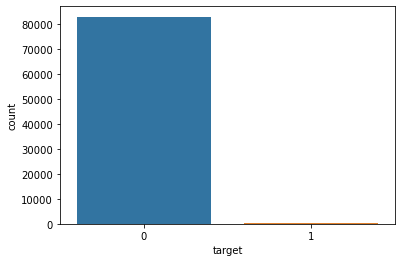

In [5]:
sns.countplot(data['target']);
print(data['target'].value_counts())

Создадим новые признаки:

*number_of_sites* — количество посещенных сайтов за сессию

*session_duration* — длительность сессии в секундах

*minute* — минута начала сессии (от 0 до 59)

*hour* — час начала сессии (от 0 до 23)

*day* — день сессии (от 1 до 31)

*weekday* — день недели сессии (от 0 до 6)

*month* — месяц начала сессии (от 1 до 12)

In [3]:
def create_features(data):
    times = ['time' + str(i) for i in range(1, 21)]
    sites = ['site' + str(i) for i in range(1, 21)]

    data[times] = data[times].apply(pd.to_datetime)
    data['target'] = data['target'].astype('int')
    data['number_of_sites'] = ((data.notna().sum(axis=1)) -1) / 2
    data['number_of_sites'] = data['number_of_sites'].astype('int64')
    data['session_start'] = data[[f"time{i}" for i in range(1,11)]].min(axis=1)
    data['session_end'] = data[[f"time{i}" for i in range(1,11)]].max(axis=1)
    data['session_duration'] = (data['session_end'] - data['session_start']).dt.seconds
    data['minute'] = data['session_start'].dt.minute
    data['hour'] = data['session_start'].dt.hour
    data['hour'] = data['hour'].astype('category')
    data['day'] = data['session_start'].dt.day
    data['day'] = data['day'].astype('category')
    data['weekday'] = data['session_start'].dt.dayofweek
    data['weekday'] = data['weekday'].astype('category')
    data['month'] = data['session_start'].dt.month
    del data['session_start']
    del data['session_end']

In [4]:
%%time
create_features(data)
data

Wall time: 3.52 s


,time1,site1,time2,site2,time3,site3,time4,site4,time5,site5,...,time20,site20,target,number_of_sites,session_duration,minute,hour,day,weekday,month
0,2013-11-15 08:01:09,www.google.fr,2013-11-15 08:01:10,www.google.fr,2013-11-15 08:01:11,apis.google.com,2013-11-15 08:01:12,www.google.com,2013-11-15 08:01:16,www.google.fr,...,NaT,NaN,0,18,57,1,8,15,4,11
1,2013-11-15 08:04:12,armmf.adobe.com,2013-11-15 08:05:31,www.google.fr,2013-11-15 08:05:32,apis.google.com,2013-11-15 08:05:32,www.google.com,2013-11-15 08:05:35,www.google.fr,...,2013-11-15 08:06:29,www.google.com,0,20,97,4,8,15,4,11
2,2013-11-15 08:06:29,www.google.fr,2013-11-15 08:06:30,www.google.fr,2013-11-15 08:06:30,ajax.googleapis.com,2013-11-15 08:06:30,www.sol-solution.com,2013-11-15 08:06:31,www.sol-solution.com,...,2013-11-15 08:07:53,www.apogeedigital.com,0,20,47,6,8,15,4,11
3,2013-11-15 08:07:35,www.google.com,2013-11-15 08:07:35,www.google.fr,2013-11-15 08:07:47,www.google.fr,2013-11-15 08:07:47,apis.google.com,2013-11-15 08:07:47,id.google.fr,...,2013-11-15 08:08:39,blast.ncbi.nlm.nih.gov,0,20,32,7,8,15,4,11
4,2013-11-15 08:07:54,www.apogeedigital.com,2013-11-15 08:07:55,www.apogeedigital.com,2013-11-15 08:08:00,www.apogeedigital.com,2013-11-15 08:08:01,www.apogeedigital.com,2013-11-15 08:08:02,www.apogeedigital.com,...,2013-11-15 08:08:28,www.apogeedigital.com,0,20,12,7,8,15,4,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83261,2014-05-28 19:02:25,www.mangareader.net,2014-05-28 19:02:25,www.facebook.com,2014-05-28 19:02:51,www.mangareader.net,2014-05-28 19:02:52,www.facebook.com,2014-05-28 19:02:53,i6.mangareader.net,...,2014-05-28 19:03:03,www.mangareader.net,0,20,32,2,19,28,2,5
83262,2014-05-28 19:03:03,i5.mangareader.net,2014-05-28 19:03:04,www.facebook.com,2014-05-28 19:03:04,www.mangareader.net,2014-05-28 19:03:50,www.mangareader.net,2014-05-28 19:03:51,www.mangareader.net,...,2014-05-28 19:05:03,www.mangareader.net,0,20,65,3,19,28,2,5
83263,2014-05-28 19:05:35,www.mangareader.net,2014-05-28 19:05:36,www.facebook.com,2014-05-28 19:05:36,www.mangareader.net,2014-05-28 19:06:01,www.mangareader.net,2014-05-28 19:06:02,www.mangareader.net,...,2014-05-28 19:07:25,www.facebook.com,0,20,85,5,19,28,2,5
83264,2014-05-28 19:07:38,www.mangareader.net,2014-05-28 19:07:39,www.mangareader.net,2014-05-28 19:07:40,www.facebook.com,2014-05-28 19:07:46,www.mangareader.net,2014-05-28 19:07:47,www.mangareader.net,...,2014-05-28 19:10:00,www.facebook.com,0,20,28,7,19,28,2,5


Построим графики и попробуем выявить закономерности

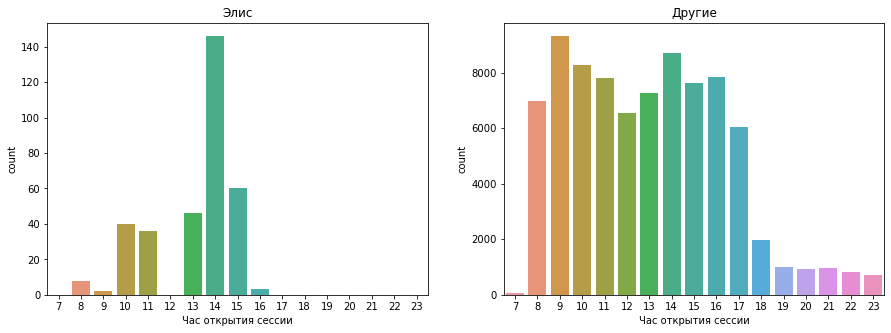

In [69]:
plt.subplots(1, 2, figsize = (15, 5)) 

plt.subplot(1, 2, 1)
sns.countplot(data[data.target == 1].hour)
plt.title("Элис")
plt.xlabel('Час открытия сессии')
          
plt.subplot(1, 2, 2)
sns.countplot(data[data.target == 0].hour)
plt.title('Другие')
plt.xlabel('Час открытия сессии');

Можно отметить, что чаще всего Элис выходит в 10, 11, 13, 14 и 15 часах. Для того, чтобы учитывать эту закономерность, создадим признак *favorite_hours*. Он будет равен 1, если сессия начата в 10, 11, 13, 14 и 15 часах.

In [5]:
data['favourite_hour'] = data['hour'].apply(lambda x: (x >= 10) & (x <= 11) | (x >= 13) & (x <= 15)).astype('int')
data

,time1,site1,time2,site2,time3,site3,time4,site4,time5,site5,...,site20,target,number_of_sites,session_duration,minute,hour,day,weekday,month,favourite_hour
0,2013-11-15 08:01:09,www.google.fr,2013-11-15 08:01:10,www.google.fr,2013-11-15 08:01:11,apis.google.com,2013-11-15 08:01:12,www.google.com,2013-11-15 08:01:16,www.google.fr,...,NaN,0,18,57,1,8,15,4,11,0
1,2013-11-15 08:04:12,armmf.adobe.com,2013-11-15 08:05:31,www.google.fr,2013-11-15 08:05:32,apis.google.com,2013-11-15 08:05:32,www.google.com,2013-11-15 08:05:35,www.google.fr,...,www.google.com,0,20,97,4,8,15,4,11,0
2,2013-11-15 08:06:29,www.google.fr,2013-11-15 08:06:30,www.google.fr,2013-11-15 08:06:30,ajax.googleapis.com,2013-11-15 08:06:30,www.sol-solution.com,2013-11-15 08:06:31,www.sol-solution.com,...,www.apogeedigital.com,0,20,47,6,8,15,4,11,0
3,2013-11-15 08:07:35,www.google.com,2013-11-15 08:07:35,www.google.fr,2013-11-15 08:07:47,www.google.fr,2013-11-15 08:07:47,apis.google.com,2013-11-15 08:07:47,id.google.fr,...,blast.ncbi.nlm.nih.gov,0,20,32,7,8,15,4,11,0
4,2013-11-15 08:07:54,www.apogeedigital.com,2013-11-15 08:07:55,www.apogeedigital.com,2013-11-15 08:08:00,www.apogeedigital.com,2013-11-15 08:08:01,www.apogeedigital.com,2013-11-15 08:08:02,www.apogeedigital.com,...,www.apogeedigital.com,0,20,12,7,8,15,4,11,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83261,2014-05-28 19:02:25,www.mangareader.net,2014-05-28 19:02:25,www.facebook.com,2014-05-28 19:02:51,www.mangareader.net,2014-05-28 19:02:52,www.facebook.com,2014-05-28 19:02:53,i6.mangareader.net,...,www.mangareader.net,0,20,32,2,19,28,2,5,0
83262,2014-05-28 19:03:03,i5.mangareader.net,2014-05-28 19:03:04,www.facebook.com,2014-05-28 19:03:04,www.mangareader.net,2014-05-28 19:03:50,www.mangareader.net,2014-05-28 19:03:51,www.mangareader.net,...,www.mangareader.net,0,20,65,3,19,28,2,5,0
83263,2014-05-28 19:05:35,www.mangareader.net,2014-05-28 19:05:36,www.facebook.com,2014-05-28 19:05:36,www.mangareader.net,2014-05-28 19:06:01,www.mangareader.net,2014-05-28 19:06:02,www.mangareader.net,...,www.facebook.com,0,20,85,5,19,28,2,5,0
83264,2014-05-28 19:07:38,www.mangareader.net,2014-05-28 19:07:39,www.mangareader.net,2014-05-28 19:07:40,www.facebook.com,2014-05-28 19:07:46,www.mangareader.net,2014-05-28 19:07:47,www.mangareader.net,...,www.facebook.com,0,20,28,7,19,28,2,5,0


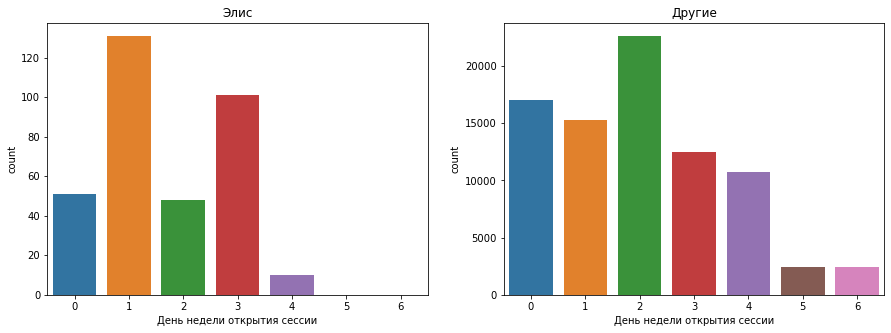

In [71]:
plt.subplots(1, 2, figsize = (15, 5)) 

plt.subplot(1, 2, 1)
sns.countplot(data[data.target == 1].weekday)
plt.title("Элис")
plt.xlabel('День недели открытия сессии')
          
plt.subplot(1, 2, 2)
sns.countplot(data[data.target == 0].weekday)
plt.title('Другие')
plt.xlabel('День недели открытия сессии');

Как видно, Элис не посещает интернет по выходным. Также создадим признак *favorite_weekdays*, который равен 1, если днем недели сессии является: понедельник, вторник среда, четверг или пятница.

In [6]:
data['favourite_weekday'] = data['weekday'].apply(lambda x: (x >= 0) & (x <= 4)).astype('int')
data

,time1,site1,time2,site2,time3,site3,time4,site4,time5,site5,...,target,number_of_sites,session_duration,minute,hour,day,weekday,month,favourite_hour,favourite_weekday
0,2013-11-15 08:01:09,www.google.fr,2013-11-15 08:01:10,www.google.fr,2013-11-15 08:01:11,apis.google.com,2013-11-15 08:01:12,www.google.com,2013-11-15 08:01:16,www.google.fr,...,0,18,57,1,8,15,4,11,0,1
1,2013-11-15 08:04:12,armmf.adobe.com,2013-11-15 08:05:31,www.google.fr,2013-11-15 08:05:32,apis.google.com,2013-11-15 08:05:32,www.google.com,2013-11-15 08:05:35,www.google.fr,...,0,20,97,4,8,15,4,11,0,1
2,2013-11-15 08:06:29,www.google.fr,2013-11-15 08:06:30,www.google.fr,2013-11-15 08:06:30,ajax.googleapis.com,2013-11-15 08:06:30,www.sol-solution.com,2013-11-15 08:06:31,www.sol-solution.com,...,0,20,47,6,8,15,4,11,0,1
3,2013-11-15 08:07:35,www.google.com,2013-11-15 08:07:35,www.google.fr,2013-11-15 08:07:47,www.google.fr,2013-11-15 08:07:47,apis.google.com,2013-11-15 08:07:47,id.google.fr,...,0,20,32,7,8,15,4,11,0,1
4,2013-11-15 08:07:54,www.apogeedigital.com,2013-11-15 08:07:55,www.apogeedigital.com,2013-11-15 08:08:00,www.apogeedigital.com,2013-11-15 08:08:01,www.apogeedigital.com,2013-11-15 08:08:02,www.apogeedigital.com,...,0,20,12,7,8,15,4,11,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83261,2014-05-28 19:02:25,www.mangareader.net,2014-05-28 19:02:25,www.facebook.com,2014-05-28 19:02:51,www.mangareader.net,2014-05-28 19:02:52,www.facebook.com,2014-05-28 19:02:53,i6.mangareader.net,...,0,20,32,2,19,28,2,5,0,1
83262,2014-05-28 19:03:03,i5.mangareader.net,2014-05-28 19:03:04,www.facebook.com,2014-05-28 19:03:04,www.mangareader.net,2014-05-28 19:03:50,www.mangareader.net,2014-05-28 19:03:51,www.mangareader.net,...,0,20,65,3,19,28,2,5,0,1
83263,2014-05-28 19:05:35,www.mangareader.net,2014-05-28 19:05:36,www.facebook.com,2014-05-28 19:05:36,www.mangareader.net,2014-05-28 19:06:01,www.mangareader.net,2014-05-28 19:06:02,www.mangareader.net,...,0,20,85,5,19,28,2,5,0,1
83264,2014-05-28 19:07:38,www.mangareader.net,2014-05-28 19:07:39,www.mangareader.net,2014-05-28 19:07:40,www.facebook.com,2014-05-28 19:07:46,www.mangareader.net,2014-05-28 19:07:47,www.mangareader.net,...,0,20,28,7,19,28,2,5,0,1


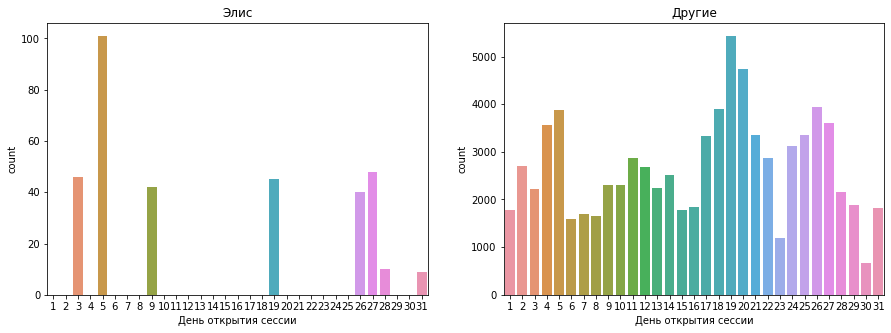

In [78]:
plt.subplots(1, 2, figsize = (15, 5)) 

plt.subplot(1, 2, 1)
sns.countplot(data[data.target == 1].day)
plt.title("Элис")
plt.xlabel('День открытия сессии')
          
plt.subplot(1, 2, 2)
sns.countplot(data[data.target == 0].day)
plt.title('Другие')
plt.xlabel('День открытия сессии');

По диаграммам видно, что Элис выходит в интернет 3, 5, 9, 19, 26, 27, 28, и 31 числа. Возможно, некоторые данные были утрачены из программного сбоя или еще каким-либо причинам. Тем не менее, эту закономерность неоходимо использовать в модели, поэтому создадим признак *favorite_days*, который равен 1, если день открытия сессии равен одному из вышеперечисленных дней.

In [7]:
data['favourite_day'] = data['day'].apply(lambda x: (x == 3) | (x == 5) | (x == 9) | (x == 19) | (x == 26) | (x == 27) | (x == 28) | (x == 31)).astype('int')
data

,time1,site1,time2,site2,time3,site3,time4,site4,time5,site5,...,number_of_sites,session_duration,minute,hour,day,weekday,month,favourite_hour,favourite_weekday,favourite_day
0,2013-11-15 08:01:09,www.google.fr,2013-11-15 08:01:10,www.google.fr,2013-11-15 08:01:11,apis.google.com,2013-11-15 08:01:12,www.google.com,2013-11-15 08:01:16,www.google.fr,...,18,57,1,8,15,4,11,0,1,0
1,2013-11-15 08:04:12,armmf.adobe.com,2013-11-15 08:05:31,www.google.fr,2013-11-15 08:05:32,apis.google.com,2013-11-15 08:05:32,www.google.com,2013-11-15 08:05:35,www.google.fr,...,20,97,4,8,15,4,11,0,1,0
2,2013-11-15 08:06:29,www.google.fr,2013-11-15 08:06:30,www.google.fr,2013-11-15 08:06:30,ajax.googleapis.com,2013-11-15 08:06:30,www.sol-solution.com,2013-11-15 08:06:31,www.sol-solution.com,...,20,47,6,8,15,4,11,0,1,0
3,2013-11-15 08:07:35,www.google.com,2013-11-15 08:07:35,www.google.fr,2013-11-15 08:07:47,www.google.fr,2013-11-15 08:07:47,apis.google.com,2013-11-15 08:07:47,id.google.fr,...,20,32,7,8,15,4,11,0,1,0
4,2013-11-15 08:07:54,www.apogeedigital.com,2013-11-15 08:07:55,www.apogeedigital.com,2013-11-15 08:08:00,www.apogeedigital.com,2013-11-15 08:08:01,www.apogeedigital.com,2013-11-15 08:08:02,www.apogeedigital.com,...,20,12,7,8,15,4,11,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83261,2014-05-28 19:02:25,www.mangareader.net,2014-05-28 19:02:25,www.facebook.com,2014-05-28 19:02:51,www.mangareader.net,2014-05-28 19:02:52,www.facebook.com,2014-05-28 19:02:53,i6.mangareader.net,...,20,32,2,19,28,2,5,0,1,1
83262,2014-05-28 19:03:03,i5.mangareader.net,2014-05-28 19:03:04,www.facebook.com,2014-05-28 19:03:04,www.mangareader.net,2014-05-28 19:03:50,www.mangareader.net,2014-05-28 19:03:51,www.mangareader.net,...,20,65,3,19,28,2,5,0,1,1
83263,2014-05-28 19:05:35,www.mangareader.net,2014-05-28 19:05:36,www.facebook.com,2014-05-28 19:05:36,www.mangareader.net,2014-05-28 19:06:01,www.mangareader.net,2014-05-28 19:06:02,www.mangareader.net,...,20,85,5,19,28,2,5,0,1,1
83264,2014-05-28 19:07:38,www.mangareader.net,2014-05-28 19:07:39,www.mangareader.net,2014-05-28 19:07:40,www.facebook.com,2014-05-28 19:07:46,www.mangareader.net,2014-05-28 19:07:47,www.mangareader.net,...,20,28,7,19,28,2,5,0,1,1


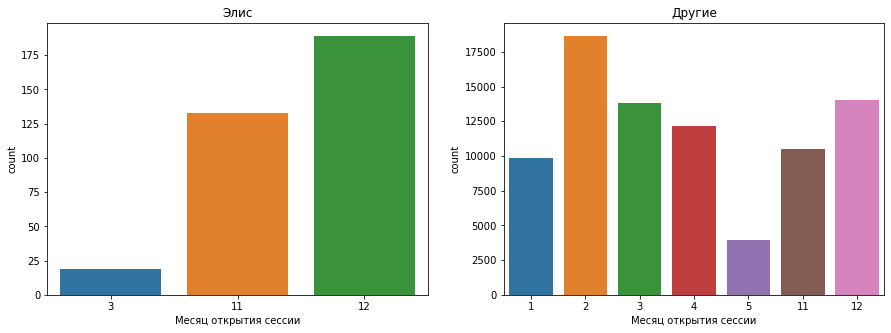

In [73]:
plt.subplots(1, 2, figsize = (15, 5)) 

plt.subplot(1, 2, 1)
sns.countplot(data[data.target == 1].month)
plt.title("Элис")
plt.xlabel('Месяц открытия сессии')
          
plt.subplot(1, 2, 2)
sns.countplot(data[data.target == 0].month)
plt.title('Другие')
plt.xlabel('Месяц открытия сессии');

Из вышеприведенных диаграмм заметна странная закономерность или какая-то аномалия. По ним можно сделать вывод, что Элис выходит в интернет только в марте, ноябре и декабре. Возможно, что это ошибка в данных, но тем не менее это нужно учитывать в модели. Создадим признак *favorite_month*. Он равен 1, если сессия открыта в марте, ноябре или декабре.

In [8]:
data['favourite_month'] = data['month'].apply(lambda x: (x == 3) | (x == 11) | (x == 12)).astype('int')
data

,time1,site1,time2,site2,time3,site3,time4,site4,time5,site5,...,session_duration,minute,hour,day,weekday,month,favourite_hour,favourite_weekday,favourite_day,favourite_month
0,2013-11-15 08:01:09,www.google.fr,2013-11-15 08:01:10,www.google.fr,2013-11-15 08:01:11,apis.google.com,2013-11-15 08:01:12,www.google.com,2013-11-15 08:01:16,www.google.fr,...,57,1,8,15,4,11,0,1,0,1
1,2013-11-15 08:04:12,armmf.adobe.com,2013-11-15 08:05:31,www.google.fr,2013-11-15 08:05:32,apis.google.com,2013-11-15 08:05:32,www.google.com,2013-11-15 08:05:35,www.google.fr,...,97,4,8,15,4,11,0,1,0,1
2,2013-11-15 08:06:29,www.google.fr,2013-11-15 08:06:30,www.google.fr,2013-11-15 08:06:30,ajax.googleapis.com,2013-11-15 08:06:30,www.sol-solution.com,2013-11-15 08:06:31,www.sol-solution.com,...,47,6,8,15,4,11,0,1,0,1
3,2013-11-15 08:07:35,www.google.com,2013-11-15 08:07:35,www.google.fr,2013-11-15 08:07:47,www.google.fr,2013-11-15 08:07:47,apis.google.com,2013-11-15 08:07:47,id.google.fr,...,32,7,8,15,4,11,0,1,0,1
4,2013-11-15 08:07:54,www.apogeedigital.com,2013-11-15 08:07:55,www.apogeedigital.com,2013-11-15 08:08:00,www.apogeedigital.com,2013-11-15 08:08:01,www.apogeedigital.com,2013-11-15 08:08:02,www.apogeedigital.com,...,12,7,8,15,4,11,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83261,2014-05-28 19:02:25,www.mangareader.net,2014-05-28 19:02:25,www.facebook.com,2014-05-28 19:02:51,www.mangareader.net,2014-05-28 19:02:52,www.facebook.com,2014-05-28 19:02:53,i6.mangareader.net,...,32,2,19,28,2,5,0,1,1,0
83262,2014-05-28 19:03:03,i5.mangareader.net,2014-05-28 19:03:04,www.facebook.com,2014-05-28 19:03:04,www.mangareader.net,2014-05-28 19:03:50,www.mangareader.net,2014-05-28 19:03:51,www.mangareader.net,...,65,3,19,28,2,5,0,1,1,0
83263,2014-05-28 19:05:35,www.mangareader.net,2014-05-28 19:05:36,www.facebook.com,2014-05-28 19:05:36,www.mangareader.net,2014-05-28 19:06:01,www.mangareader.net,2014-05-28 19:06:02,www.mangareader.net,...,85,5,19,28,2,5,0,1,1,0
83264,2014-05-28 19:07:38,www.mangareader.net,2014-05-28 19:07:39,www.mangareader.net,2014-05-28 19:07:40,www.facebook.com,2014-05-28 19:07:46,www.mangareader.net,2014-05-28 19:07:47,www.mangareader.net,...,28,7,19,28,2,5,0,1,1,0


In [20]:
new_features_data = data[['number_of_sites', 'session_duration', 'minute', 'hour', 'favourite_hour', 'weekday', 'favourite_weekday', 'day', 'favourite_day', 'month', 'favourite_month']]
new_features_data

,number_of_sites,session_duration,minute,hour,favourite_hour,weekday,favourite_weekday,day,favourite_day,month,favourite_month
0,18,57,1,8,0,4,1,15,0,11,1
1,20,97,4,8,0,4,1,15,0,11,1
2,20,47,6,8,0,4,1,15,0,11,1
3,20,32,7,8,0,4,1,15,0,11,1
4,20,12,7,8,0,4,1,15,0,11,1
...,...,...,...,...,...,...,...,...,...,...,...
83261,20,32,2,19,0,2,1,28,1,5,0
83262,20,65,3,19,0,2,1,28,1,5,0
83263,20,85,5,19,0,2,1,28,1,5,0
83264,20,28,7,19,0,2,1,28,1,5,0


Произведем отбор признаков по критериям Фишера и хи-квадрат

In [21]:
target = data['target'].values
best_f_features = SelectKBest(f_classif, k = 4)
best_chi2_features = SelectKBest(chi2, k = 4)
best_f_features.fit(new_features_data, target)
best_chi2_features.fit(new_features_data, target)
print('f:', np.sort(best_f_features.pvalues_))
print('f:', best_f_features.get_support())
print('chi2:', np.sort(best_chi2_features.pvalues_))
print('chi2:', best_chi2_features.get_support())

f: [1.23708819e-169 6.79263559e-144 3.69274380e-088 3.61335417e-071
 2.87816401e-014 1.09693024e-006 4.12184087e-006 3.57216610e-005
 1.03618013e-003 4.47066836e-001 4.52777207e-001]
f: [False False False False  True False False False  True  True  True]
chi2: [0.00000000e+000 0.00000000e+000 2.23340627e-117 5.55378112e-048
 9.52786424e-038 3.29561604e-034 1.83824637e-024 6.59042546e-006
 1.65614749e-002 2.66113255e-001 4.69518692e-001]
chi2: [False  True False False False False False False  True  True  True]


In [22]:
best_f_features = ['favourite_hour', 'favourite_day', 'month', 'favourite_month']
best_chi2_features = ['session_duration', 'favourite_day', 'month', 'favourite_month']
new_features_data_scaled = StandardScaler().fit_transform(new_features_data)
new_features_data_scaled = pd.DataFrame(new_features_data_scaled, index = new_features_data.index, columns = new_features_data.columns)
new_features_data_scaled

,number_of_sites,session_duration,minute,hour,favourite_hour,weekday,favourite_weekday,day,favourite_day,month,favourite_month
0,0.238657,-0.138558,-1.642500,-1.448831,-0.962118,1.280211,0.248859,-0.143741,-0.668052,1.351748,1.074437
1,0.546087,0.155705,-1.469287,-1.448831,-0.962118,1.280211,0.248859,-0.143741,-0.668052,1.351748,1.074437
2,0.546087,-0.212124,-1.353812,-1.448831,-0.962118,1.280211,0.248859,-0.143741,-0.668052,1.351748,1.074437
3,0.546087,-0.322473,-1.296074,-1.448831,-0.962118,1.280211,0.248859,-0.143741,-0.668052,1.351748,1.074437
4,0.546087,-0.469604,-1.296074,-1.448831,-0.962118,1.280211,0.248859,-0.143741,-0.668052,1.351748,1.074437
...,...,...,...,...,...,...,...,...,...,...,...
83261,0.546087,-0.322473,-1.584762,1.763061,-0.962118,-0.011284,0.248859,1.397661,1.496890,-0.080312,-0.930720
83262,0.546087,-0.079705,-1.527025,1.763061,-0.962118,-0.011284,0.248859,1.397661,1.496890,-0.080312,-0.930720
83263,0.546087,0.067426,-1.411549,1.763061,-0.962118,-0.011284,0.248859,1.397661,1.496890,-0.080312,-0.930720
83264,0.546087,-0.351899,-1.296074,1.763061,-0.962118,-0.011284,0.248859,1.397661,1.496890,-0.080312,-0.930720


In [23]:
f_features_data_scaled = new_features_data_scaled[best_f_features]
chi2_features_data_scaled = new_features_data_scaled[best_chi2_features]

Векторизуем данные с помощью tf-idf

In [19]:
sites = ['site' + str(i) for i in range(1, 21)]
data[sites].to_csv('sessions_domains.txt', 
                                 sep=' ', index=None, header=None)

In [20]:
vectorizer = TfidfVectorizer()
with open('sessions_domains.txt') as inp_file:
    data_tfidf = vectorizer.fit_transform(inp_file)
data_tfidf

<83266x22725 sparse matrix of type '<class 'numpy.float64'>'
	with 1239071 stored elements in Compressed Sparse Row format>

Делим выборку на тестовую и обучающую

In [24]:
X_train , X_valid , y_train , y_valid = train_test_split(data_tfidf, target ,test_size=0.3, random_state=42)

Приступим к обучению моделей на первом наборе данных

Логистическая регрессия:

In [25]:
parameters = [
    {'penalty' : ['none', 'l1', 'l2', 'elasticnet'],
    'C' : [0.001,0.01,0.1,1,10,100,1000],
    'solver' : ['liblinear', 'lbfgs']}]
logit = LogisticRegression()
grid_logit = GridSearchCV(logit, parameters, n_jobs=-1)

In [26]:
%%time
grid_logit.fit(X_train, y_train)

Wall time: 3min 24s


GridSearchCV(estimator=LogisticRegression(), n_jobs=-1,
             param_grid=[{'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                          'penalty': ['none', 'l1', 'l2', 'elasticnet'],
                          'solver': ['liblinear', 'lbfgs']}])

In [45]:
pred_logit_proba = grid_logit.predict_proba(X_valid)[:, 1]
pred_logit = grid_logit.predict(X_valid)

print(roc_auc_score (y_valid, pred_logit_proba))
print(accuracy_score(y_valid, pred_logit))
print(recall_score(y_valid, pred_logit))
print(precision_score(y_valid, pred_logit))
print(f1_score(y_valid, pred_logit))
print(matthews_corrcoef(y_valid, pred_logit))

grid_logit.best_params_

0.9642000051852194
0.9965172137710168
0.2803738317757009
0.75
0.40816326530612235
0.4572903392907317


{'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}

Случайный лес:

In [30]:
parameters = [
    {'criterion' : ['gini', 'entropy'],
    'max_features' : ['auto', 'sqrt', 'log2']}]
rf = RandomForestClassifier()
grid_rf = GridSearchCV(rf, parameters, n_jobs=-1)

In [31]:
%%time
grid_rf.fit(X_train, y_train)

Wall time: 10min 12s


GridSearchCV(estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid=[{'criterion': ['gini', 'entropy'],
                          'max_features': ['auto', 'sqrt', 'log2']}])

In [46]:
pred_rf_proba = grid_rf.predict_proba(X_valid)[:, 1]
pred_rf = grid_rf.predict(X_valid)

print(roc_auc_score (y_valid, pred_rf_proba))
print(accuracy_score(y_valid, pred_rf))
print(recall_score(y_valid, pred_rf))
print(precision_score(y_valid, pred_rf))
print(f1_score(y_valid, pred_rf))
print(matthews_corrcoef(y_valid, pred_rf))

grid_rf.best_params_

0.9108754716952774
0.9960768614891914
0.09345794392523364
0.9090909090909091
0.16949152542372883
0.2907959887248898


{'criterion': 'gini', 'max_features': 'sqrt'}

Дерево решений:

In [33]:
parameters = [
    {'criterion' : ['gini', 'entropy'],
    'max_features' : ['auto', 'sqrt', 'log2']}]
dt = DecisionTreeClassifier()
grid_dt = GridSearchCV(dt, parameters, n_jobs=-1)

In [34]:
%%time
grid_dt.fit(X_train, y_train)

Wall time: 8.81 s


GridSearchCV(estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid=[{'criterion': ['gini', 'entropy'],
                          'max_features': ['auto', 'sqrt', 'log2']}])

In [47]:
pred_dt_proba = grid_dt.predict_proba(X_valid)[:, 1]
pred_dt = grid_dt.predict(X_valid)

print(roc_auc_score (y_valid, pred_dt_proba))
print(accuracy_score(y_valid, pred_dt))
print(recall_score(y_valid, pred_dt))
print(precision_score(y_valid, pred_dt))
print(f1_score(y_valid, pred_dt))
print(matthews_corrcoef(y_valid, pred_dt))

grid_dt.best_params_

0.6294753046410344
0.99435548438751
0.19626168224299065
0.27631578947368424
0.2295081967213115
0.23010670635057562


{'criterion': 'entropy', 'max_features': 'sqrt'}

Градиентный бустинг:

In [36]:
parameters = [
    {'loss' : ['deviance', 'exponential'],
    'max_features' : ['auto', 'sqrt', 'log2']}]
gb = GradientBoostingClassifier()
grid_gb = GridSearchCV(gb, parameters, n_jobs=-1)

In [37]:
%%time
grid_gb.fit(X_train, y_train)

Wall time: 7min 24s


GridSearchCV(estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid=[{'loss': ['deviance', 'exponential'],
                          'max_features': ['auto', 'sqrt', 'log2']}])

In [48]:
pred_gb_proba = grid_gb.predict_proba(X_valid)[:, 1]
pred_gb = grid_gb.predict(X_valid)

print(roc_auc_score (y_valid, pred_gb_proba))
print(accuracy_score(y_valid, pred_gb))
print(recall_score(y_valid, pred_gb))
print(precision_score(y_valid, pred_gb))
print(f1_score(y_valid, pred_gb))
print(matthews_corrcoef(y_valid, pred_gb))

grid_gb.best_params_

0.7647965684368179
0.9957165732586069
0.0
0.0
0.0
0.0


{'loss': 'exponential', 'max_features': 'auto'}

Адаптивный бустинг:

In [39]:
parameters = [
    {'algorithm' : ['SAMME', 'SAMME.R']}]
ab = AdaBoostClassifier()
grid_ab = GridSearchCV(ab, parameters, n_jobs=-1)

In [40]:
%%time
grid_ab.fit(X_train, y_train)

Wall time: 3min 4s


GridSearchCV(estimator=AdaBoostClassifier(), n_jobs=-1,
             param_grid=[{'algorithm': ['SAMME', 'SAMME.R']}])

In [49]:
pred_ab_proba = grid_ab.predict_proba(X_valid)[:, 1]
pred_ab = grid_ab.predict(X_valid)

print(roc_auc_score (y_valid, pred_ab_proba))
print(accuracy_score(y_valid, pred_ab))
print(recall_score(y_valid, pred_ab))
print(precision_score(y_valid, pred_ab))
print(f1_score(y_valid, pred_ab))
print(matthews_corrcoef(y_valid, pred_ab))

grid_ab.best_params_

0.9154121629466475
0.9963570856685349
0.16822429906542055
0.9
0.28346456692913385
0.3882395523364101


{'algorithm': 'SAMME.R'}

Метод опорных векторов:

In [42]:
parameters = [
    {'kernel' : ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma' : ['scale', 'auto'],
    'probability' : [True]}]
svc = SVC()
grid_svc = GridSearchCV(svc, parameters, n_jobs=-1)

In [43]:
%%time
grid_svc.fit(X_train, y_train)

Wall time: 21min 3s


GridSearchCV(estimator=SVC(), n_jobs=-1,
             param_grid=[{'gamma': ['scale', 'auto'],
                          'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                          'probability': [True]}])

In [50]:
pred_svc_proba = grid_svc.predict_proba(X_valid)[:, 1]
pred_svc = grid_svc.predict(X_valid)

print(roc_auc_score (y_valid, pred_svc))
print(accuracy_score(y_valid, pred_svc))
print(recall_score(y_valid, pred_svc))
print(precision_score(y_valid, pred_svc))
print(f1_score(y_valid, pred_svc))
print(matthews_corrcoef(y_valid, pred_svc))

grid_svc.best_params_

0.5326901782550685
0.9959567654123299
0.06542056074766354
0.875
0.12173913043478259
0.23863360469119135


{'gamma': 'scale', 'kernel': 'linear', 'probability': True}

Теперь обучим модели на втором наборе данных

In [53]:
data_tfidf = sparse.hstack((data_tfidf,new_features_data_scaled))
data_tfidf

<83266x22736 sparse matrix of type '<class 'numpy.float64'>'
	with 2154997 stored elements in COOrdinate format>

Снова разделим данные на тренировочные и тестовые

In [54]:
X_train , X_valid , y_train , y_valid = train_test_split(data_tfidf, target ,test_size=0.3, random_state=42)

Логистическая регрессия:

In [55]:
parameters = [
    {'penalty' : ['none', 'l1', 'l2', 'elasticnet'],
    'C' : [0.001,0.01,0.1,1,10,100,1000],
    'solver' : ['liblinear', 'lbfgs']}]
logit = LogisticRegression()
grid_logit = GridSearchCV(logit, parameters, n_jobs=-1)

In [56]:
%%time
grid_logit.fit(X_train, y_train)

Wall time: 16min 13s


GridSearchCV(estimator=LogisticRegression(), n_jobs=-1,
             param_grid=[{'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                          'penalty': ['none', 'l1', 'l2', 'elasticnet'],
                          'solver': ['liblinear', 'lbfgs']}])

In [57]:
pred_logit_proba = grid_logit.predict_proba(X_valid)[:, 1]
pred_logit = grid_logit.predict(X_valid)

print(roc_auc_score (y_valid, pred_logit_proba))
print(accuracy_score(y_valid, pred_logit))
print(recall_score(y_valid, pred_logit))
print(precision_score(y_valid, pred_logit))
print(f1_score(y_valid, pred_logit))
print(matthews_corrcoef(y_valid, pred_logit))

grid_logit.best_params_

0.9971315967357165
0.9979183346677342
0.5981308411214953
0.8767123287671232
0.7111111111111109
0.7232146658766788


{'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}

Случайный лес:

In [58]:
parameters = [
    {'criterion' : ['gini', 'entropy'],
    'max_features' : ['auto', 'sqrt', 'log2']}]
rf = RandomForestClassifier()
grid_rf = GridSearchCV(rf, parameters, n_jobs=-1)

In [59]:
%%time
grid_rf.fit(X_train, y_train)

Wall time: 6min 32s


GridSearchCV(estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid=[{'criterion': ['gini', 'entropy'],
                          'max_features': ['auto', 'sqrt', 'log2']}])

In [60]:
pred_rf_proba = grid_rf.predict_proba(X_valid)[:, 1]
pred_rf = grid_rf.predict(X_valid)

print(roc_auc_score (y_valid, pred_rf_proba))
print(accuracy_score(y_valid, pred_rf))
print(recall_score(y_valid, pred_rf))
print(precision_score(y_valid, pred_rf))
print(f1_score(y_valid, pred_rf))
print(matthews_corrcoef(y_valid, pred_rf))

grid_rf.best_params_

0.9644303341347877
0.9963570856685349
0.1588785046728972
0.9444444444444444
0.272
0.38657633404451547


{'criterion': 'gini', 'max_features': 'sqrt'}

Дерево решений:

In [61]:
parameters = [
    {'criterion' : ['gini', 'entropy'],
    'max_features' : ['auto', 'sqrt', 'log2']}]
dt = DecisionTreeClassifier()
grid_dt = GridSearchCV(dt, parameters, n_jobs=-1)

In [62]:
%%time
grid_dt.fit(X_train, y_train)

Wall time: 5.91 s


GridSearchCV(estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid=[{'criterion': ['gini', 'entropy'],
                          'max_features': ['auto', 'sqrt', 'log2']}])

In [63]:
pred_dt_proba = grid_dt.predict_proba(X_valid)[:, 1]
pred_dt = grid_dt.predict(X_valid)

print(roc_auc_score (y_valid, pred_dt_proba))
print(accuracy_score(y_valid, pred_dt))
print(recall_score(y_valid, pred_dt))
print(precision_score(y_valid, pred_dt))
print(f1_score(y_valid, pred_dt))
print(matthews_corrcoef(y_valid, pred_dt))

grid_dt.best_params_

0.6527984591632032
0.9942353883106485
0.308411214953271
0.32038834951456313
0.3142857142857143
0.3114492782580766


{'criterion': 'gini', 'max_features': 'sqrt'}

Градиентный бустинг:

In [64]:
parameters = [
    {'loss' : ['deviance', 'exponential'],
    'max_features' : ['auto', 'sqrt', 'log2']}]
gb = GradientBoostingClassifier()
grid_gb = GridSearchCV(gb, parameters, n_jobs=-1)

In [65]:
%%time
grid_gb.fit(X_train, y_train)

Wall time: 7min 46s


GridSearchCV(estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid=[{'loss': ['deviance', 'exponential'],
                          'max_features': ['auto', 'sqrt', 'log2']}])

In [66]:
pred_gb_proba = grid_gb.predict_proba(X_valid)[:, 1]
pred_gb = grid_gb.predict(X_valid)

print(roc_auc_score (y_valid, pred_gb_proba))
print(accuracy_score(y_valid, pred_gb))
print(recall_score(y_valid, pred_gb))
print(precision_score(y_valid, pred_gb))
print(f1_score(y_valid, pred_gb))
print(matthews_corrcoef(y_valid, pred_gb))

grid_gb.best_params_

0.9696965256399707
0.9957165732586069
0.0
0.0
0.0
0.0


{'loss': 'exponential', 'max_features': 'auto'}

Адаптивный бустинг:

In [67]:
parameters = [
    {'algorithm' : ['SAMME', 'SAMME.R']}]
ab = AdaBoostClassifier()
grid_ab = GridSearchCV(ab, parameters, n_jobs=-1)

In [68]:
%%time
grid_ab.fit(X_train, y_train)

Wall time: 3min 8s


GridSearchCV(estimator=AdaBoostClassifier(), n_jobs=-1,
             param_grid=[{'algorithm': ['SAMME', 'SAMME.R']}])

In [69]:
pred_ab_proba = grid_ab.predict_proba(X_valid)[:, 1]
pred_ab = grid_ab.predict(X_valid)

print(roc_auc_score (y_valid, pred_ab_proba))
print(accuracy_score(y_valid, pred_ab))
print(recall_score(y_valid, pred_ab))
print(precision_score(y_valid, pred_ab))
print(f1_score(y_valid, pred_ab))
print(matthews_corrcoef(y_valid, pred_ab))

grid_ab.best_params_

0.9947165244300862
0.9969175340272218
0.411214953271028
0.7586206896551724
0.5333333333333333
0.5572172759566243


{'algorithm': 'SAMME.R'}

Метод опорных векторов:

In [70]:
parameters = [
    {'kernel' : ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma' : ['scale', 'auto'],
    'probability' : [True]}]
svc = SVC()
grid_svc = GridSearchCV(svc, parameters, n_jobs=-1)

In [71]:
%%time
grid_svc.fit(X_train, y_train)

Wall time: 6min 52s


GridSearchCV(estimator=SVC(), n_jobs=-1,
             param_grid=[{'gamma': ['scale', 'auto'],
                          'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                          'probability': [True]}])

In [72]:
pred_svc_proba = grid_svc.predict_proba(X_valid)[:, 1]
pred_svc = grid_svc.predict(X_valid)

print(roc_auc_score (y_valid, pred_svc_proba))
print(accuracy_score(y_valid, pred_svc))
print(recall_score(y_valid, pred_svc))
print(precision_score(y_valid, pred_svc))
print(f1_score(y_valid, pred_svc))
print(matthews_corrcoef(y_valid, pred_svc))

grid_svc.best_params_

0.9920978007530592
0.9975980784627703
0.4672897196261682
0.9433962264150944
0.625
0.6630665936862797


{'gamma': 'scale', 'kernel': 'linear', 'probability': True}

Затем обучим модели на третьем наборе данных

In [74]:
vectorizer = TfidfVectorizer()
with open('sessions_domains.txt') as inp_file:
    data_tfidf = vectorizer.fit_transform(inp_file)

In [75]:
data_tfidf = sparse.hstack((data_tfidf,f_features_data_scaled))
data_tfidf

<83266x22729 sparse matrix of type '<class 'numpy.float64'>'
	with 1572135 stored elements in COOrdinate format>

In [76]:
X_train , X_valid , y_train , y_valid = train_test_split(data_tfidf, target ,test_size=0.3, random_state=42)

Логистическая регрессия:

In [77]:
parameters = [
    {'penalty' : ['none', 'l1', 'l2', 'elasticnet'],
    'C' : [0.001,0.01,0.1,1,10,100,1000],
    'solver' : ['liblinear', 'lbfgs']}]
logit = LogisticRegression()
grid_logit = GridSearchCV(logit, parameters, n_jobs=-1)

In [78]:
%%time
grid_logit.fit(X_train, y_train)

Wall time: 16min 55s


GridSearchCV(estimator=LogisticRegression(), n_jobs=-1,
             param_grid=[{'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                          'penalty': ['none', 'l1', 'l2', 'elasticnet'],
                          'solver': ['liblinear', 'lbfgs']}])

In [79]:
pred_logit_proba = grid_logit.predict_proba(X_valid)[:, 1]
pred_logit = grid_logit.predict(X_valid)

print(roc_auc_score (y_valid, pred_logit_proba))
print(accuracy_score(y_valid, pred_logit))
print(recall_score(y_valid, pred_logit))
print(precision_score(y_valid, pred_logit))
print(f1_score(y_valid, pred_logit))
print(matthews_corrcoef(y_valid, pred_logit))

grid_logit.best_params_

0.9970773022280286
0.9977181745396317
0.5700934579439252
0.8472222222222222
0.6815642458100558
0.6939518250263517


{'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}

Случайный лес:

In [80]:
parameters = [
    {'criterion' : ['gini', 'entropy'],
    'max_features' : ['auto', 'sqrt', 'log2']}]
rf = RandomForestClassifier()
grid_rf = GridSearchCV(rf, parameters, n_jobs=-1)

In [81]:
%%time
grid_rf.fit(X_train, y_train)

Wall time: 7min 21s


GridSearchCV(estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid=[{'criterion': ['gini', 'entropy'],
                          'max_features': ['auto', 'sqrt', 'log2']}])

In [82]:
pred_rf_proba = grid_rf.predict_proba(X_valid)[:, 1]
pred_rf = grid_rf.predict(X_valid)

print(roc_auc_score (y_valid, pred_rf_proba))
print(accuracy_score(y_valid, pred_rf))
print(recall_score(y_valid, pred_rf))
print(precision_score(y_valid, pred_rf))
print(f1_score(y_valid, pred_rf))
print(matthews_corrcoef(y_valid, pred_rf))

grid_rf.best_params_

0.9543114535860865
0.9963971176941553
0.1588785046728972
1.0
0.27419354838709675
0.3978764812058109


{'criterion': 'entropy', 'max_features': 'auto'}

Дерево решений:

In [83]:
parameters = [
    {'criterion' : ['gini', 'entropy'],
    'max_features' : ['auto', 'sqrt', 'log2']}]
dt = DecisionTreeClassifier()
grid_dt = GridSearchCV(dt, parameters, n_jobs=-1)

In [84]:
%%time
grid_dt.fit(X_train, y_train)

Wall time: 7.52 s


GridSearchCV(estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid=[{'criterion': ['gini', 'entropy'],
                          'max_features': ['auto', 'sqrt', 'log2']}])

In [85]:
pred_dt_proba = grid_dt.predict_proba(X_valid)[:, 1]
pred_dt = grid_dt.predict(X_valid)

print(roc_auc_score (y_valid, pred_dt_proba))
print(accuracy_score(y_valid, pred_dt))
print(recall_score(y_valid, pred_dt))
print(precision_score(y_valid, pred_dt))
print(f1_score(y_valid, pred_dt))
print(matthews_corrcoef(y_valid, pred_dt))

grid_dt.best_params_

0.638716643164096
0.9945956765412329
0.22429906542056074
0.3157894736842105
0.26229508196721313
0.26349670219509846


{'criterion': 'entropy', 'max_features': 'auto'}

Градиентный бустинг:

In [86]:
parameters = [
    {'loss' : ['deviance', 'exponential'],
    'max_features' : ['auto', 'sqrt', 'log2']}]
gb = GradientBoostingClassifier()
grid_gb = GridSearchCV(gb, parameters, n_jobs=-1)

In [87]:
%%time
grid_gb.fit(X_train, y_train)

Wall time: 8min 34s


GridSearchCV(estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid=[{'loss': ['deviance', 'exponential'],
                          'max_features': ['auto', 'sqrt', 'log2']}])

In [88]:
pred_gb_proba = grid_gb.predict_proba(X_valid)[:, 1]
pred_gb = grid_gb.predict(X_valid)

print(roc_auc_score (y_valid, pred_gb_proba))
print(accuracy_score(y_valid, pred_gb))
print(recall_score(y_valid, pred_gb))
print(precision_score(y_valid, pred_gb))
print(f1_score(y_valid, pred_gb))
print(matthews_corrcoef(y_valid, pred_gb))

grid_gb.best_params_

0.9725577898340393
0.9957165732586069
0.0
0.0
0.0
0.0


{'loss': 'exponential', 'max_features': 'auto'}

Адаптивный бустинг:

In [89]:
parameters = [
    {'algorithm' : ['SAMME', 'SAMME.R']}]
ab = AdaBoostClassifier()
grid_ab = GridSearchCV(ab, parameters, n_jobs=-1)

In [90]:
%%time
grid_ab.fit(X_train, y_train)

Wall time: 4min 17s


GridSearchCV(estimator=AdaBoostClassifier(), n_jobs=-1,
             param_grid=[{'algorithm': ['SAMME', 'SAMME.R']}])

In [91]:
pred_ab_proba = grid_ab.predict_proba(X_valid)[:, 1]
pred_ab = grid_ab.predict(X_valid)

print(roc_auc_score (y_valid, pred_ab_proba))
print(accuracy_score(y_valid, pred_ab))
print(recall_score(y_valid, pred_ab))
print(precision_score(y_valid, pred_ab))
print(f1_score(y_valid, pred_ab))
print(matthews_corrcoef(y_valid, pred_ab))

grid_ab.best_params_

0.9895837208157627
0.9970776621297037
0.38317757009345793
0.8541666666666666
0.529032258064516
0.5710022041471491


{'algorithm': 'SAMME.R'}

Метод опорных векторов:

In [92]:
parameters = [
    {'kernel' : ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma' : ['scale', 'auto'],
    'probability' : [True]}]
svc = SVC()
grid_svc = GridSearchCV(svc, parameters, n_jobs=-1)

In [93]:
%%time
grid_svc.fit(X_train, y_train)

Wall time: 9min 53s


GridSearchCV(estimator=SVC(), n_jobs=-1,
             param_grid=[{'gamma': ['scale', 'auto'],
                          'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                          'probability': [True]}])

In [94]:
pred_svc_proba = grid_svc.predict_proba(X_valid)[:, 1]
pred_svc = grid_svc.predict(X_valid)

print(roc_auc_score (y_valid, pred_svc_proba))
print(accuracy_score(y_valid, pred_svc))
print(recall_score(y_valid, pred_svc))
print(precision_score(y_valid, pred_svc))
print(f1_score(y_valid, pred_svc))
print(matthews_corrcoef(y_valid, pred_svc))

grid_svc.best_params_

0.994795429942989
0.9977982385908727
0.514018691588785
0.9482758620689655
0.6666666666666666
0.6973126202264947


{'gamma': 'scale', 'kernel': 'poly', 'probability': True}

Далее обучим модели на четвертом наборе данных

In [98]:
vectorizer = TfidfVectorizer()
with open('sessions_domains.txt') as inp_file:
    data_tfidf = vectorizer.fit_transform(inp_file)

In [99]:
data_tfidf = sparse.hstack((data_tfidf,chi2_features_data_scaled))
data_tfidf

<83266x22729 sparse matrix of type '<class 'numpy.float64'>'
	with 1572135 stored elements in COOrdinate format>

In [100]:
X_train , X_valid , y_train , y_valid = train_test_split(data_tfidf, target ,test_size=0.3, random_state=42)

Логистическая регрессия:

In [101]:
parameters = [
    {'penalty' : ['none', 'l1', 'l2', 'elasticnet'],
    'C' : [0.001,0.01,0.1,1,10,100,1000],
    'solver' : ['liblinear', 'lbfgs']}]
logit = LogisticRegression()
grid_logit = GridSearchCV(logit, parameters, n_jobs=-1)

In [102]:
%%time
grid_logit.fit(X_train, y_train)

Wall time: 10min 52s


GridSearchCV(estimator=LogisticRegression(), n_jobs=-1,
             param_grid=[{'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                          'penalty': ['none', 'l1', 'l2', 'elasticnet'],
                          'solver': ['liblinear', 'lbfgs']}])

In [103]:
pred_logit_proba = grid_logit.predict_proba(X_valid)[:, 1]
pred_logit = grid_logit.predict(X_valid)

print(roc_auc_score (y_valid, pred_logit_proba))
print(accuracy_score(y_valid, pred_logit))
print(recall_score(y_valid, pred_logit))
print(precision_score(y_valid, pred_logit))
print(f1_score(y_valid, pred_logit))
print(matthews_corrcoef(y_valid, pred_logit))

grid_logit.best_params_

0.9958168805945418
0.9976781425140112
0.5607476635514018
0.8450704225352113
0.6741573033707865
0.6873429369444551


{'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}

Случайный лес:

In [104]:
parameters = [
    {'criterion' : ['gini', 'entropy'],
    'max_features' : ['auto', 'sqrt', 'log2']}]
rf = RandomForestClassifier()
grid_rf = GridSearchCV(rf, parameters, n_jobs=-1)

In [105]:
%%time
grid_rf.fit(X_train, y_train)

Wall time: 7min 35s


GridSearchCV(estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid=[{'criterion': ['gini', 'entropy'],
                          'max_features': ['auto', 'sqrt', 'log2']}])

In [106]:
pred_rf_proba = grid_rf.predict_proba(X_valid)[:, 1]
pred_rf = grid_rf.predict(X_valid)

print(roc_auc_score (y_valid, pred_rf_proba))
print(accuracy_score(y_valid, pred_rf))
print(recall_score(y_valid, pred_rf))
print(precision_score(y_valid, pred_rf))
print(f1_score(y_valid, pred_rf))
print(matthews_corrcoef(y_valid, pred_rf))

grid_rf.best_params_

0.9543875410449569
0.9963971176941553
0.16822429906542055
0.9473684210526315
0.2857142857142857
0.3984126372231842


{'criterion': 'gini', 'max_features': 'sqrt'}

Дерево решений:

In [107]:
parameters = [
    {'criterion' : ['gini', 'entropy'],
    'max_features' : ['auto', 'sqrt', 'log2']}]
dt = DecisionTreeClassifier()
grid_dt = GridSearchCV(dt, parameters, n_jobs=-1)

In [108]:
%%time
grid_dt.fit(X_train, y_train)

Wall time: 7.36 s


GridSearchCV(estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid=[{'criterion': ['gini', 'entropy'],
                          'max_features': ['auto', 'sqrt', 'log2']}])

In [109]:
pred_dt_proba = grid_dt.predict_proba(X_valid)[:, 1]
pred_dt = grid_dt.predict(X_valid)

print(roc_auc_score (y_valid, pred_dt_proba))
print(accuracy_score(y_valid, pred_dt))
print(recall_score(y_valid, pred_dt))
print(precision_score(y_valid, pred_dt))
print(f1_score(y_valid, pred_dt))
print(matthews_corrcoef(y_valid, pred_dt))

grid_dt.best_params_

0.6483542000840907
0.995236188951161
0.27102803738317754
0.4142857142857143
0.327683615819209
0.33280120975187943


{'criterion': 'entropy', 'max_features': 'auto'}

Градиентный бустинг:

In [110]:
parameters = [
    {'loss' : ['deviance', 'exponential'],
    'max_features' : ['auto', 'sqrt', 'log2']}]
gb = GradientBoostingClassifier()
grid_gb = GridSearchCV(gb, parameters, n_jobs=-1)

In [111]:
%%time
grid_gb.fit(X_train, y_train)

Wall time: 7min 31s


GridSearchCV(estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid=[{'loss': ['deviance', 'exponential'],
                          'max_features': ['auto', 'sqrt', 'log2']}])

In [112]:
pred_gb_proba = grid_gb.predict_proba(X_valid)[:, 1]
pred_gb = grid_gb.predict(X_valid)

print(roc_auc_score (y_valid, pred_gb_proba))
print(accuracy_score(y_valid, pred_gb))
print(recall_score(y_valid, pred_gb))
print(precision_score(y_valid, pred_gb))
print(f1_score(y_valid, pred_gb))
print(matthews_corrcoef(y_valid, pred_gb))

grid_gb.best_params_

0.9789295978712043
0.9957165732586069
0.0
0.0
0.0
0.0


{'loss': 'exponential', 'max_features': 'auto'}

Адаптивный бустинг:

In [113]:
parameters = [
    {'algorithm' : ['SAMME', 'SAMME.R']}]
ab = AdaBoostClassifier()
grid_ab = GridSearchCV(ab, parameters, n_jobs=-1)

In [114]:
%%time
grid_ab.fit(X_train, y_train)

Wall time: 3min 5s


GridSearchCV(estimator=AdaBoostClassifier(), n_jobs=-1,
             param_grid=[{'algorithm': ['SAMME', 'SAMME.R']}])

In [115]:
pred_ab_proba = grid_ab.predict_proba(X_valid)[:, 1]
pred_ab = grid_ab.predict(X_valid)

print(roc_auc_score (y_valid, pred_ab_proba))
print(accuracy_score(y_valid, pred_ab))
print(recall_score(y_valid, pred_ab))
print(precision_score(y_valid, pred_ab))
print(f1_score(y_valid, pred_ab))
print(matthews_corrcoef(y_valid, pred_ab))

grid_ab.best_params_

0.9887501404330259
0.9969575660528422
0.35514018691588783
0.8444444444444444
0.5
0.5465130765593748


{'algorithm': 'SAMME.R'}

Метод опорных векторов:

In [116]:
parameters = [
    {'kernel' : ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma' : ['scale', 'auto'],
    'probability' : [True]}]
svc = SVC()
grid_svc = GridSearchCV(svc, parameters, n_jobs=-1)

In [117]:
%%time
grid_svc.fit(X_train, y_train)

Wall time: 7min 26s


GridSearchCV(estimator=SVC(), n_jobs=-1,
             param_grid=[{'gamma': ['scale', 'auto'],
                          'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                          'probability': [True]}])

In [118]:
pred_svc_proba = grid_svc.predict_proba(X_valid)[:, 1]
pred_svc = grid_svc.predict(X_valid)

print(roc_auc_score (y_valid, pred_svc_proba))
print(accuracy_score(y_valid, pred_svc))
print(recall_score(y_valid, pred_svc))
print(precision_score(y_valid, pred_svc))
print(f1_score(y_valid, pred_svc))
print(matthews_corrcoef(y_valid, pred_svc))

grid_svc.best_params_

0.9896908068689879
0.9974379503602883
0.4485981308411215
0.9056603773584906
0.6
0.6364229563058547


{'gamma': 'scale', 'kernel': 'linear', 'probability': True}

Алгоритм градиентного бустинга некорректно справляется с задачей. Попробуем изменить алгоритм векторизация на CountVectorizer

In [11]:
vectorizer = CountVectorizer()
with open('sessions_domains.txt') as inp_file:
    data_cv = vectorizer.fit_transform(inp_file)
data_cv

<83266x22725 sparse matrix of type '<class 'numpy.int64'>'
	with 1239071 stored elements in Compressed Sparse Row format>

In [15]:
X_train , X_valid , y_train , y_valid = train_test_split(data_cv, target ,test_size=0.3, random_state=42)

Градиентный бустинг на первом наборе данных

In [16]:
parameters = [
    {'loss' : ['deviance', 'exponential'],
    'max_features' : ['auto', 'sqrt', 'log2']}]
gb = GradientBoostingClassifier()
grid_gb = GridSearchCV(gb, parameters, n_jobs=-1)

In [17]:
%%time
grid_gb.fit(X_train, y_train)

Wall time: 6min 34s


GridSearchCV(estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid=[{'loss': ['deviance', 'exponential'],
                          'max_features': ['auto', 'sqrt', 'log2']}])

In [18]:
pred_gb_proba = grid_gb.predict_proba(X_valid)[:, 1]
pred_gb = grid_gb.predict(X_valid)

print(roc_auc_score (y_valid, pred_gb_proba))
print(accuracy_score(y_valid, pred_gb))
print(recall_score(y_valid, pred_gb))
print(precision_score(y_valid, pred_gb))
print(f1_score(y_valid, pred_gb))
print(matthews_corrcoef(y_valid, pred_gb))

grid_gb.best_params_

0.7850409049936293
0.9953162530024019
0.22429906542056074
0.41379310344827586
0.2909090909090909
0.3024984681932234


{'loss': 'deviance', 'max_features': 'auto'}

Градиентный бустинг на втором наборе данных

In [24]:
data_cv = sparse.hstack((data_cv,new_features_data_scaled))
data_cv

<83266x22736 sparse matrix of type '<class 'numpy.float64'>'
	with 2154997 stored elements in COOrdinate format>

In [27]:
X_train , X_valid , y_train , y_valid = train_test_split(data_cv, target ,test_size=0.3, random_state=42)

In [30]:
%%time
grid_gb.fit(X_train, y_train)

Wall time: 7min 11s


GridSearchCV(estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid=[{'loss': ['deviance', 'exponential'],
                          'max_features': ['auto', 'sqrt', 'log2']}])

In [31]:
pred_gb_proba = grid_gb.predict_proba(X_valid)[:, 1]
pred_gb = grid_gb.predict(X_valid)

print(roc_auc_score (y_valid, pred_gb_proba))
print(accuracy_score(y_valid, pred_gb))
print(recall_score(y_valid, pred_gb))
print(precision_score(y_valid, pred_gb))
print(f1_score(y_valid, pred_gb))
print(matthews_corrcoef(y_valid, pred_gb))

grid_gb.best_params_

0.972461975996943
0.9969175340272218
0.40186915887850466
0.7678571428571429
0.5276073619631902
0.5542077225043468


{'loss': 'deviance', 'max_features': 'auto'}

Градиентный бустинг на третьем наборе данных

In [32]:
vectorizer = CountVectorizer()
with open('sessions_domains.txt') as inp_file:
    data_cv = vectorizer.fit_transform(inp_file)

In [34]:
data_cv = sparse.hstack((data_cv,f_features_data_scaled))
data_cv

<83266x22729 sparse matrix of type '<class 'numpy.float64'>'
	with 1572135 stored elements in COOrdinate format>

In [35]:
X_train , X_valid , y_train , y_valid = train_test_split(data_cv, target ,test_size=0.3, random_state=42)

In [36]:
%%time
grid_gb.fit(X_train, y_train)

Wall time: 6min 40s


GridSearchCV(estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid=[{'loss': ['deviance', 'exponential'],
                          'max_features': ['auto', 'sqrt', 'log2']}])

In [37]:
pred_gb_proba = grid_gb.predict_proba(X_valid)[:, 1]
pred_gb = grid_gb.predict(X_valid)

print(roc_auc_score (y_valid, pred_gb_proba))
print(accuracy_score(y_valid, pred_gb))
print(recall_score(y_valid, pred_gb))
print(precision_score(y_valid, pred_gb))
print(f1_score(y_valid, pred_gb))
print(matthews_corrcoef(y_valid, pred_gb))

grid_gb.best_params_

0.7909411586560661
0.9966773418734988
0.4953271028037383
0.6463414634146342
0.5608465608465608
0.564203065620916


{'loss': 'deviance', 'max_features': 'auto'}

Градиентный бустинг на четвертом наборе данных

In [38]:
vectorizer = CountVectorizer()
with open('sessions_domains.txt') as inp_file:
    data_cv = vectorizer.fit_transform(inp_file)

In [40]:
data_cv = sparse.hstack((data_cv,chi2_features_data_scaled))
data_cv

<83266x22729 sparse matrix of type '<class 'numpy.float64'>'
	with 1572135 stored elements in COOrdinate format>

In [41]:
X_train , X_valid , y_train , y_valid = train_test_split(data_cv, target ,test_size=0.3, random_state=42)

In [42]:
%%time
grid_gb.fit(X_train, y_train)

Wall time: 6min 49s


GridSearchCV(estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid=[{'loss': ['deviance', 'exponential'],
                          'max_features': ['auto', 'sqrt', 'log2']}])

In [43]:
pred_gb_proba = grid_gb.predict_proba(X_valid)[:, 1]
pred_gb = grid_gb.predict(X_valid)

print(roc_auc_score (y_valid, pred_gb_proba))
print(accuracy_score(y_valid, pred_gb))
print(recall_score(y_valid, pred_gb))
print(precision_score(y_valid, pred_gb))
print(f1_score(y_valid, pred_gb))
print(matthews_corrcoef(y_valid, pred_gb))

grid_gb.best_params_

0.967238994653588
0.9964371497197758
0.42990654205607476
0.6216216216216216
0.5082872928176796
0.5152564962255609


{'loss': 'deviance', 'max_features': 'auto'}